<a href="https://colab.research.google.com/github/doremon020848/stat-2/blob/main/%E0%B8%AA%E0%B8%B3%E0%B9%80%E0%B8%99%E0%B8%B2%E0%B8%82%E0%B8%AD%E0%B8%87_Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

[Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/)

In [1]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [2]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [3]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [5]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [6]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [7]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


#### Visualize the first four images in the batch

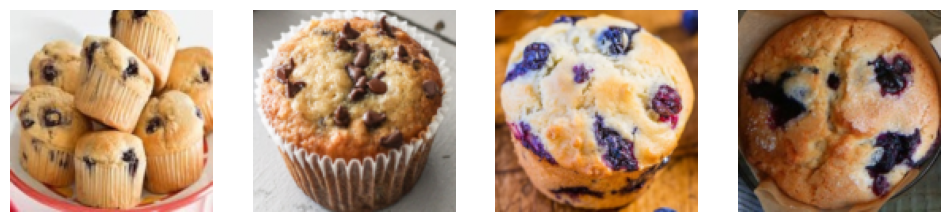

tensor([1, 1, 1, 1])


In [8]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  

[Linear layer in Pytorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)

[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [10]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super().__init__()
    # self.flatten = nn.Flatten()
    self.lin1 = nn.Linear(128 * 128 * 3, 100)
    self.act1 = nn.ReLU()
    self.lin2 = nn.Linear(100, 50)
    self.act2 = nn.ReLU()
    self.lin3 = nn.Linear(50, 1)

  def forward(self, x):
    x = x.view(x.size(0), -1) # Replaced nn.Flatten with direct tensor view
    x = self.lin1(x)
    x = self.act1(x)
    x = self.lin2(x)
    x = self.act2(x)
    x = self.lin3(x)
    return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [11]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()

#### Manually setting initial weights to zero for demonstration

In [12]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [13]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [14]:
learning_rate = 1e-3
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [15]:

X, y = next(iter(train_batches))

#### Make a prediction on the minibatch (Forward pass)

In [16]:

y_hat = model(X)
y = y.to(torch.float32)
y_hat = y_hat[:, 0]

#y_hat = y_hat[:, 0]
#y = y.to(torch.float32)

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [17]:
# Compute the loss
train_loss = criterion(y_hat, y)
train_losses.append(train_loss.item())

In [18]:
train_loss

tensor(6.9078, grad_fn=<DivBackward1>)

#### Calculate the gradient (Backward pass)

In [19]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
train_loss.backward()

#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [20]:
# Update the weights using the gradient descent rule
optimizer.step() #parameter - learning rate * gradiant of parameter

# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [21]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    print(y_hat, y)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010]) tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
        0., 1., 0., 0., 0., 1.])


In [22]:
print(train_losses)
print(val_losses)

[6.907755374908447]
[28.60248374938965]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

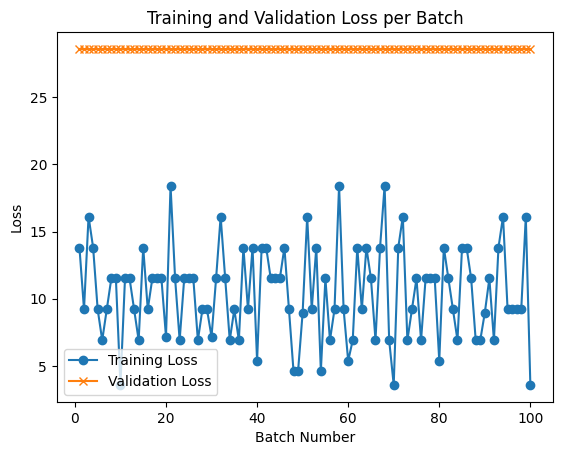

In [23]:
model = SimpleLogisticRegression()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()
    optimizer.step()

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [24]:
import torch.nn as nn

class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super().__init__()
    # Define layers for the 3-hidden layer neural network
    self.lin1 = nn.Linear(128 * 128 * 3, 128)
    self.act1 = nn.ReLU()
    self.lin2 = nn.Linear(128, 64)
    self.act2 = nn.ReLU()
    self.lin3 = nn.Linear(64, 32) # Third hidden layer
    self.act3 = nn.ReLU()
    self.lin4 = nn.Linear(32, 2) # Output layer

  def forward(self, x):
    x = x.view(x.size(0), -1) # Flatten the input
    x = self.lin1(x)
    x = self.act1(x)
    x = self.lin2(x)
    x = self.act2(x)
    x = self.lin3(x)
    x = self.act3(x)
    x = self.lin4(x)
    return x


In [25]:

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
all_histories = {}

for lr_val in learning_rates:
    model = SimpleLogisticRegression()
    optimizer = optim.SGD(model.parameters(), lr=lr_val, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    current_lr_losses = []
    print(f"กำลังเทรน LR: {lr_val}...")

    # Create a fresh iterator for each learning rate to avoid StopIteration
    train_iter = iter(train_loader)

    for _ in range(20):
        try:
            X, y = next(train_iter)
        except StopIteration:
            # If iterator is exhausted, reset it to loop through data again
            train_iter = iter(train_loader)
            X, y = next(train_iter)

        optimizer.zero_grad()
        y_hat = model(X)
        y = y.to(torch.long) # Ensure y is long type for CrossEntropyLoss
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        current_lr_losses.append(loss.item())

    all_histories[lr_val] = current_lr_losses
    print(f"เสร็จสิ้น! Loss สุดท้าย: {current_lr_losses[-1]:.4f}")

กำลังเทรน LR: 0.01...
เสร็จสิ้น! Loss สุดท้าย: 0.7204
กำลังเทรน LR: 0.001...
เสร็จสิ้น! Loss สุดท้าย: 0.6678
กำลังเทรน LR: 0.0001...
เสร็จสิ้น! Loss สุดท้าย: 0.6771
กำลังเทรน LR: 1e-05...
เสร็จสิ้น! Loss สุดท้าย: 0.7076


2.1 ) ใช้ learing rate ที่ 0.001 มีค่า Loss อยู่ที่ 0.6917 ซึ่งเข้าใกล้ 0 มากที่สุด

2.2 )หาค่า learning rate สูงไปอาจทำให้เกิดการผันผวนได้ทำให้โมเดลหาค่าที่เข้าใกล้ 0 ไม่เจอ

2.3 ) หากค่า learning rate น้อยไปจะทำให้ค่า Loss ลดลงช้ามากใช้เวลานาน

In [26]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X) # y_hat is (batch_size, 2)

  # Get predicted class indices (0 or 1) from the raw logits
  predictions = torch.argmax(y_hat, dim=1)

  correct = (predictions == y).float().sum() # Compare predicted indices with true labels
  total = y.size(0)                    # Number of samples in this batch
  accuracy = (correct / total) * 100    # Calculate as percentage

print(f"Test Accuracy: {accuracy.item():.2f}%")

Test Accuracy: 43.33%


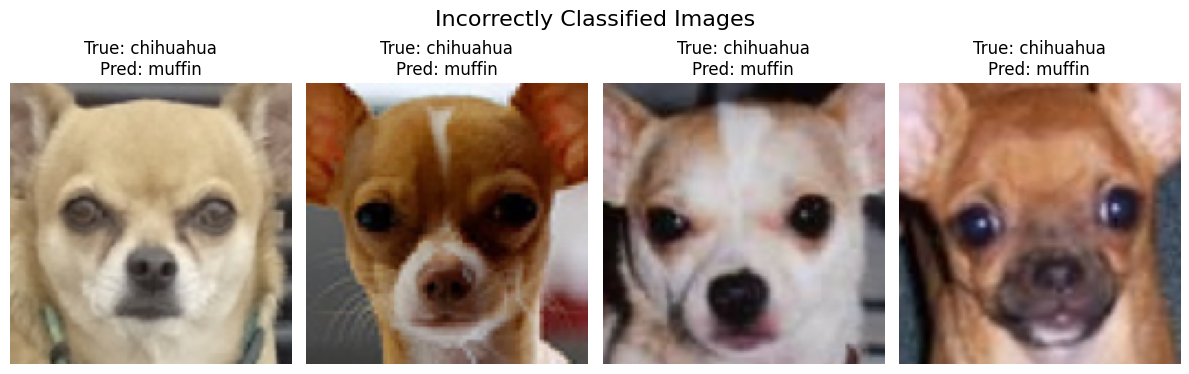

In [27]:
import matplotlib.pyplot as plt

# Assuming X, y, and predictions are available from the last execution of the test accuracy cell
# If not, re-run the test accuracy cell (3uTeAOXwShVE) first.

# Find indices where predictions do not match true labels
incorrect_indices = (predictions != y).nonzero(as_tuple=True)[0]

# Select up to 4 incorrectly classified images and their labels
num_to_display = min(len(incorrect_indices), 4)
images_to_display = X[incorrect_indices[:num_to_display]]
true_labels = y[incorrect_indices[:num_to_display]]
predicted_labels = predictions[incorrect_indices[:num_to_display]]

# Convert images from (B, C, H, W) to (B, H, W, C) for matplotlib
images_to_display = images_to_display.numpy().transpose(0, 2, 3, 1)

# Map numerical labels to class names (assuming 0 for Chihuahua, 1 for Muffin)
class_names = dataset.classes # Assuming dataset.classes gives ['Chihuahua', 'Muffin'] or similar

# Plot images
fig, axes = plt.subplots(1, num_to_display, figsize=(12, 4))
if num_to_display == 1:
    axes = [axes] # Make it iterable if only one image

for i in range(num_to_display):
    axes[i].imshow(images_to_display[i])
    axes[i].axis('off')
    axes[i].set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")

plt.suptitle('Incorrectly Classified Images', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()